In [50]:
from pathlib import Path
import json

import pandas as pd
import matplotlib.pyplot as plt

from evolution.candidate import Candidate
from evolution.evaluation.evaluator import Evaluator

In [51]:
results_dir = Path("results/coal/longer")
config = json.load(open(results_dir / "config.json"))
gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes)

50 ['CO2 Gross emissions', 'Total cost of energy']


In [52]:
model_params = config["model_params"]
input_specs = pd.read_json("inputSpecs.jsonl", lines=True)
model_params["in_size"] = len(context) if len(context) > 0 else len(input_specs) - len(actions)
model_params["out_size"] = len(actions)

In [53]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
final_pareto

,cand_id,parents,rank,distance,CO2 Gross emissions,Total cost of energy
0,48_38,"['39_49', '47_68']",1,inf,-37.7917,-13.5631
1,46_7,"['42_84', '45_69']",1,inf,-39.1079,-13.2967
2,45_4,"['44_27', '39_49']",1,0.068831,-37.9107,-13.5417
3,47_88,"['46_49', '41_68']",1,0.053932,-38.4271,-13.3731
4,39_49,"['38_58', '38_79']",1,0.020795,-37.8333,-13.5590
5,42_84,"['40_74', '35_0']",1,0.013674,-38.7287,-13.3297
6,50_66,"['49_67', '49_69']",1,0.008160,-38.4950,-13.3620
7,50_68,"['49_36', '47_88']",1,0.007446,-38.6684,-13.3343


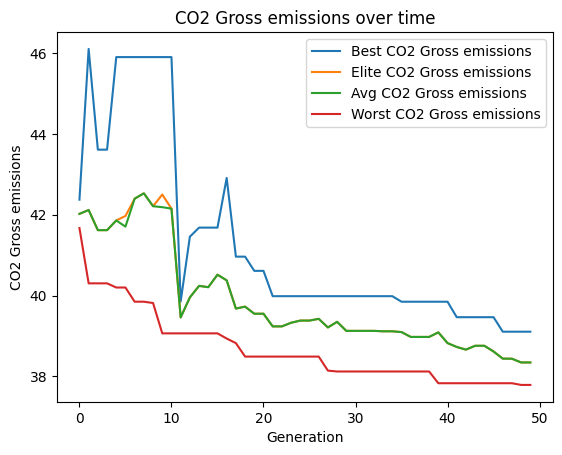

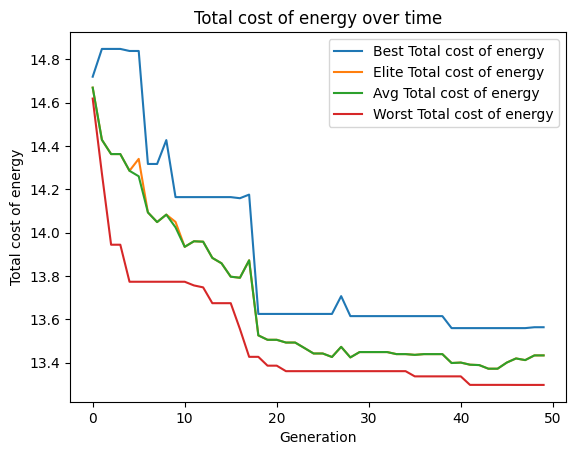

In [54]:
def plot_objective_over_time(outcome):
    best = []
    worst = []
    avg = []
    elite = []
    for gen in range(gens):
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        pareto = gen_df[gen_df["rank"] == 1]
        scores = pareto[outcome] * -1
        best.append(scores.max())
        worst.append(scores.min())
        avg.append(scores.mean())
        elite.append(scores.nlargest(n_elites).mean())
    
    plt.plot(range(gens), best, label=f"Best {outcome}")
    plt.plot(range(gens), elite, label=f"Elite {outcome}")
    plt.plot(range(gens), avg, label=f"Avg {outcome}")
    plt.plot(range(gens), worst, label=f"Worst {outcome}")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel(outcome)
    plt.title(f"{outcome} over time")
    plt.show()

for outcome in outcomes:
    plot_objective_over_time(outcome)

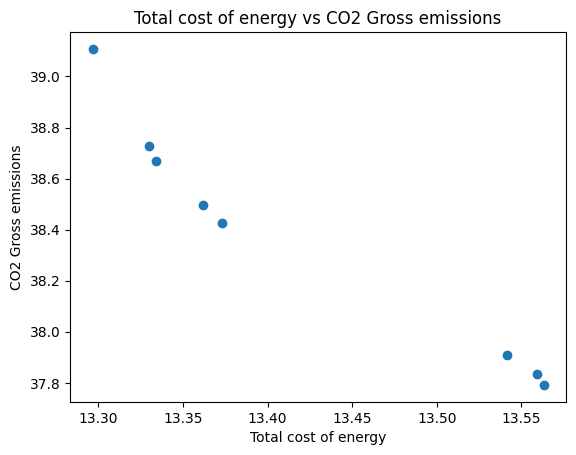

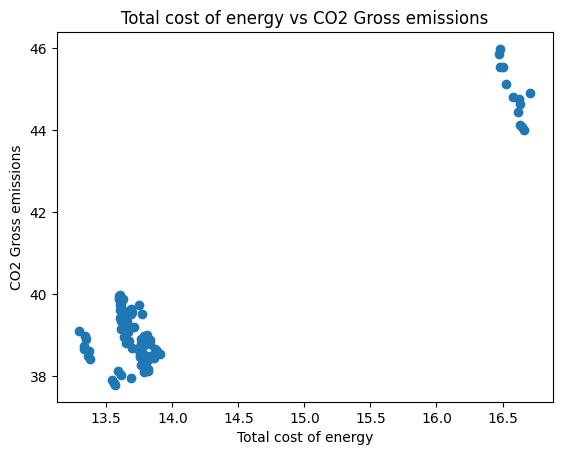

In [55]:
def plot_two_objective(outcome1, outcome2, pareto=True):
    df = final_pareto if pareto else final_gen_df
    plt.scatter(-1 * df[outcome1], -1 * df[outcome2])
    plt.title(f"{outcome1} vs {outcome2}")
    plt.ylabel(outcome2)
    plt.xlabel(outcome1)
    plt.show()

plot_two_objective(outcomes[1], outcomes[0])
plot_two_objective(outcomes[1], outcomes[0], pareto=False)

In [56]:
def get_candidate_actions(candidate: Candidate, torch_context):
    cand_actions = dict(zip(actions, candidate.prescribe(torch_context)))
    return cand_actions

def get_candidate_from_id(results_dir: Path, cand_id: str):
    cand_path = results_dir / cand_id.split("_")[0] / f"{cand_id}.pt"
    return Candidate.from_seed(cand_path, model_params, outcomes)

In [57]:
evaluator = Evaluator(context, actions, outcomes)

make: `enroads' is up to date.


In [60]:
cand = get_candidate_from_id(results_dir, "50_80")
cand_actions = get_candidate_actions(cand, evaluator.torch_context)
cand_outcomes = evaluator.evaluate_candidate(cand)
print(cand_actions)
print(cand.metrics)

{'_source_subsidy_delivered_coal_tce': 19.44548797607422, '_source_subsidy_start_time_delivered_coal': 2078.11865234375, '_source_subsidy_stop_time_delivered_coal': 2078.756591796875, '_no_new_coal': 37.60611343383789, '_year_of_no_new_capacity_coal': 2089.837646484375, '_utilization_adjustment_factor_delivered_coal': 50.490318298339844, '_utilization_policy_start_time_delivered_coal': 2040.6407470703125, '_utilization_policy_stop_time_delivered_coal': 2093.197509765625, '_target_accelerated_retirement_rate_electric_coal': 4.801971435546875}
{'CO2 Gross emissions': np.float64(-39.0874), 'Total cost of energy': np.float64(-13.7736)}
